In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
ONE_MONTH_SIM = "32763946-5ca3-4ea6-ad39-de91eb9e8908"
THREE_MONTH_SIM = "b6f34e86-dfdf-4ca3-b218-f3555c7a7f5f"
SIX_MONTH_SIM = "b017d0c1-304e-411d-a2e0-ea173b4e3200"

### Get Data

In [3]:
fpath = F"/Users/porterjenkins/Documents/delicious-ai/code/demand-simulation/experiments/runs/{SIX_MONTH_SIM}/output.csv"

In [4]:
dta = pd.read_csv(fpath)
dta = dta[dta['display']=="entrance-cooler"]
dta = dta.sort_values(by='datetime')

### EDA

In [5]:
dta.head(10)

,datetime,product,display,num_slots,quantity_sold,price,revenue
0,2021-05-01 12:00:00,coca_cola_20oz_bottle,entrance-cooler,1,10.0,1.99,19.90
1,2021-05-01 12:00:00,sprite_20oz_bottle,entrance-cooler,8,8.0,1.99,15.92
2,2021-05-01 12:00:00,Monster_16oz_can,entrance-cooler,1,10.0,2.99,29.90
5,2021-05-02 12:00:00,dr_pepper_20oz_bottle,entrance-cooler,1,0.0,0.99,0.00
6,2021-05-02 12:00:00,diet_coke_20oz_bottle,entrance-cooler,4,0.0,1.99,0.00
7,2021-05-02 12:00:00,sprite_20oz_bottle,entrance-cooler,3,11.0,1.99,21.89
8,2021-05-02 12:00:00,Monster_16oz_can,entrance-cooler,2,5.0,2.99,14.95
15,2021-05-03 12:00:00,coca_cola_20oz_bottle,entrance-cooler,2,0.0,1.99,0.00
16,2021-05-03 12:00:00,dr_pepper_20oz_bottle,entrance-cooler,3,5.0,0.99,4.95
17,2021-05-03 12:00:00,diet_coke_20oz_bottle,entrance-cooler,1,2.0,1.99,3.98


In [6]:
colors = {
    'Monster_16oz_can':'green', 
    'coca_cola_20oz_bottle':'red', 
    'diet_coke_20oz_bottle':'gray', 
    'dr_pepper_20oz_bottle':'orange',
    'sprite_20oz_bottle': 'blue'
}

Text(0, 0.5, 'quantity sold')

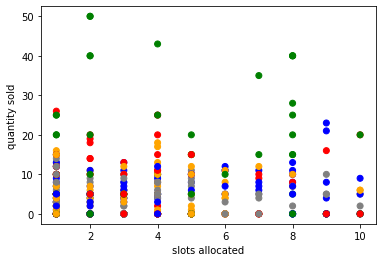

In [7]:
plt.scatter(dta["num_slots"], dta["quantity_sold"], c=dta['product'].map(colors))
plt.xlabel("slots allocated")
plt.ylabel("quantity sold")

### Preprocessing

In [8]:
slot_cnts = dta.pivot(index='datetime', columns='product', values='num_slots').fillna(0)

In [9]:
slot_cols = list(slot_cnts.columns)

In [10]:
dta = pd.merge(dta, slot_cnts, on='datetime', how='left')

In [11]:
dta['day_of_week'] = pd.to_datetime(dta["datetime"]).dt.dayofweek

In [12]:
dta.head()

,datetime,product,display,num_slots,quantity_sold,price,revenue,Monster_16oz_can,coca_cola_20oz_bottle,diet_coke_20oz_bottle,dr_pepper_20oz_bottle,sprite_20oz_bottle,day_of_week
0,2021-05-01 12:00:00,coca_cola_20oz_bottle,entrance-cooler,1,10.0,1.99,19.90,1.0,1.0,0.0,0.0,8.0,5
1,2021-05-01 12:00:00,sprite_20oz_bottle,entrance-cooler,8,8.0,1.99,15.92,1.0,1.0,0.0,0.0,8.0,5
2,2021-05-01 12:00:00,Monster_16oz_can,entrance-cooler,1,10.0,2.99,29.90,1.0,1.0,0.0,0.0,8.0,5
3,2021-05-02 12:00:00,dr_pepper_20oz_bottle,entrance-cooler,1,0.0,0.99,0.00,2.0,0.0,4.0,1.0,3.0,6
4,2021-05-02 12:00:00,diet_coke_20oz_bottle,entrance-cooler,4,0.0,1.99,0.00,2.0,0.0,4.0,1.0,3.0,6


In [13]:
naive = dta[['product','revenue']].groupby('product').mean().reset_index()
naive.rename(columns={'revenue': 'naive'}, inplace='True')

dta = pd.merge(dta, naive, on='product', how='left')

In [14]:
dta.head()

,datetime,product,display,num_slots,quantity_sold,price,revenue,Monster_16oz_can,coca_cola_20oz_bottle,diet_coke_20oz_bottle,dr_pepper_20oz_bottle,sprite_20oz_bottle,day_of_week,naive
0,2021-05-01 12:00:00,coca_cola_20oz_bottle,entrance-cooler,1,10.0,1.99,19.90,1.0,1.0,0.0,0.0,8.0,5,10.061798
1,2021-05-01 12:00:00,sprite_20oz_bottle,entrance-cooler,8,8.0,1.99,15.92,1.0,1.0,0.0,0.0,8.0,5,8.863025
2,2021-05-01 12:00:00,Monster_16oz_can,entrance-cooler,1,10.0,2.99,29.90,1.0,1.0,0.0,0.0,8.0,5,28.272111
3,2021-05-02 12:00:00,dr_pepper_20oz_bottle,entrance-cooler,1,0.0,0.99,0.00,2.0,0.0,4.0,1.0,3.0,6,3.877500
4,2021-05-02 12:00:00,diet_coke_20oz_bottle,entrance-cooler,4,0.0,1.99,0.00,2.0,0.0,4.0,1.0,3.0,6,7.249286


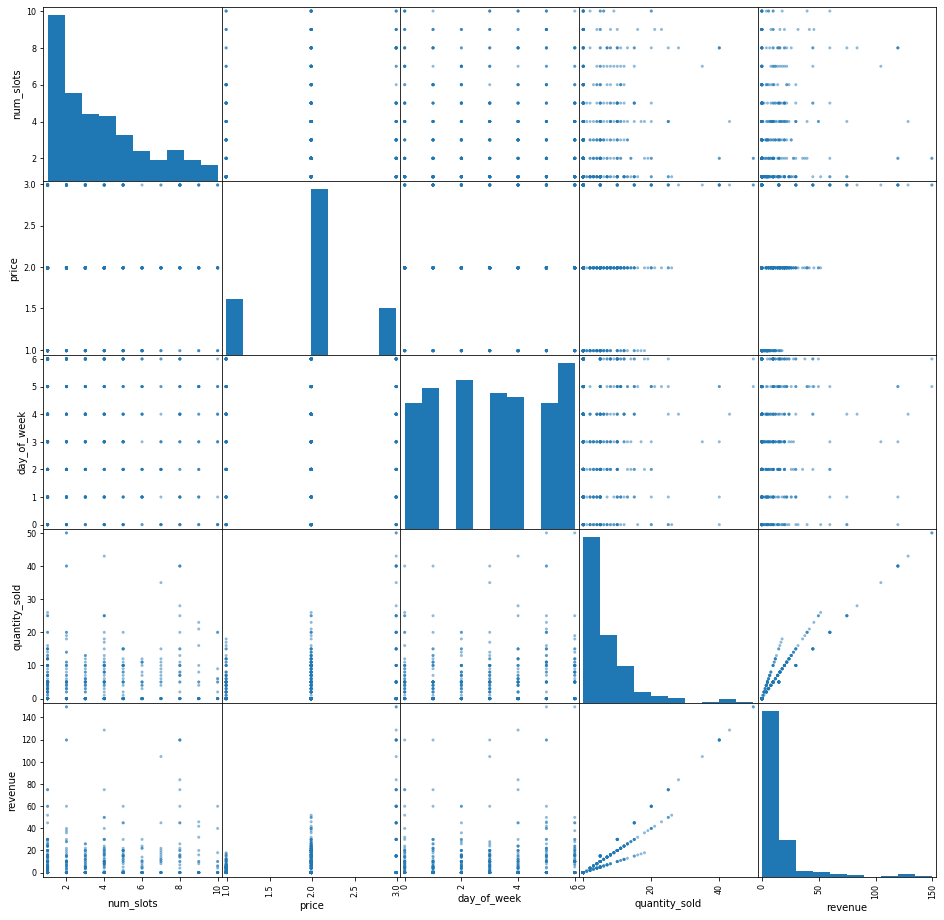

In [73]:
#fig = plt.figure()
pd.plotting.scatter_matrix(dta[['num_slots', 'price', 'day_of_week', 'product', 'quantity_sold', 'revenue']], figsize=(16,16))
#plt.savefig("scatter.png")
plt.show()

In [15]:
prod_one_hot = pd.get_dummies(dta['product'], prefix='product_one_hot')

In [16]:
X = dta[['price', 'day_of_week', 'num_slots']]

In [17]:
X = pd.concat([X, prod_one_hot], axis=1)

In [18]:
X.head()

,price,day_of_week,num_slots,product_one_hot_Monster_16oz_can,product_one_hot_coca_cola_20oz_bottle,product_one_hot_diet_coke_20oz_bottle,product_one_hot_dr_pepper_20oz_bottle,product_one_hot_sprite_20oz_bottle
0,1.99,5,1,0,1,0,0,0
1,1.99,5,8,0,0,0,0,1
2,2.99,5,1,1,0,0,0,0
3,0.99,6,1,0,0,0,1,0
4,1.99,6,4,0,0,1,0,0


In [19]:
y = dta[['revenue','price', 'quantity_sold', 'naive']]

In [20]:
y.head()

,revenue,price,quantity_sold,naive
0,19.90,1.99,10.0,10.061798
1,15.92,1.99,8.0,8.863025
2,29.90,2.99,10.0,28.272111
3,0.00,0.99,0.0,3.877500
4,0.00,1.99,0.0,7.249286


In [21]:
X.shape

(518, 8)

In [22]:
y.shape

(518, 4)

In [23]:
X

,price,day_of_week,num_slots,product_one_hot_Monster_16oz_can,product_one_hot_coca_cola_20oz_bottle,product_one_hot_diet_coke_20oz_bottle,product_one_hot_dr_pepper_20oz_bottle,product_one_hot_sprite_20oz_bottle
0,1.99,5,1,0,1,0,0,0
1,1.99,5,8,0,0,0,0,1
2,2.99,5,1,1,0,0,0,0
3,0.99,6,1,0,0,0,1,0
4,1.99,6,4,0,0,1,0,0
...,...,...,...,...,...,...,...,...
513,1.99,5,9,0,1,0,0,0
514,1.99,5,1,0,0,0,0,1
515,1.99,6,1,0,0,0,0,1
516,1.99,6,7,0,0,1,0,0


## Train/Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Linear Regression

In [45]:
TARGET = 'quantity_sold'

In [46]:
#model = LinearRegression()
model = RandomForestRegressor()

In [47]:
model 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [48]:
X_train.head()

,price,day_of_week,num_slots,product_one_hot_Monster_16oz_can,product_one_hot_coca_cola_20oz_bottle,product_one_hot_diet_coke_20oz_bottle,product_one_hot_dr_pepper_20oz_bottle,product_one_hot_sprite_20oz_bottle
138,2.99,0,3,1,0,0,0,0
74,1.99,5,4,0,1,0,0,0
263,1.99,2,8,0,0,0,0,1
500,1.99,1,6,0,0,1,0,0
48,0.99,1,1,0,0,0,1,0


In [63]:
y_test.head()

,revenue,price,quantity_sold,naive
280,74.75,2.99,25.0,28.272111
21,0.00,1.99,0.0,8.863025
0,19.90,1.99,10.0,10.061798
206,0.00,2.99,0.0,28.272111
414,0.00,1.99,0.0,8.863025


In [49]:
model.fit(X_train, y_train[TARGET])

/opt/anaconda3/envs/allocation-rl/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

,revenue,price,quantity_sold,naive
280,74.75,2.99,25.0,28.272111
21,0.00,1.99,0.0,8.863025
0,19.90,1.99,10.0,10.061798
206,0.00,2.99,0.0,28.272111
414,0.00,1.99,0.0,8.863025
...,...,...,...,...
496,3.96,0.99,4.0,3.877500
458,21.89,1.99,11.0,10.061798
404,0.00,2.99,0.0,28.272111
397,19.90,1.99,10.0,10.061798


In [51]:
output = y_test.copy()

In [52]:
y_hat =  model.predict(X_test)

In [53]:
output['y_hat']  = y_hat 
output['y_hat_revenue'] = y_hat * output['price']

In [54]:
output.head()

,revenue,price,quantity_sold,naive,y_hat,y_hat_revenue
280,74.75,2.99,25.0,28.272111,0.500000,1.495000
21,0.00,1.99,0.0,8.863025,0.866667,1.724667
0,19.90,1.99,10.0,10.061798,1.200000,2.388000
206,0.00,2.99,0.0,28.272111,0.916667,2.740833
414,0.00,1.99,0.0,8.863025,4.965238,9.880824


Text(0, 0.5, 'Predicted')

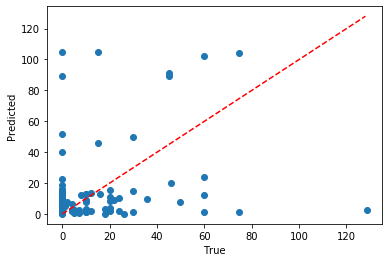

In [55]:
gt_x = np.arange(output['revenue'].max())
gt_y = np.arange(output['revenue'].max())


plt.scatter(output['revenue'], output["y_hat_revenue"])
plt.plot(gt_x, gt_y, '--', c='red')
plt.xlabel("True")
plt.ylabel("Predicted")

In [56]:
def get_mse(y_true, y_hat):
    res = y_true - y_hat
    return np.mean(np.power(res, 2))

def get_mape(y_true, y_hat):
    res = y_true - y_hat
    rel_res = res / y_true
    return np.mean(np.abs(rel_res))

def get_mae(y_true, y_hat):
    res = y_true - y_hat
    return np.mean(np.abs(res))

#### Model predictions

In [57]:
get_mse(output["revenue"].values, output["y_hat_revenue"].values)

774.9776006368879

In [58]:
get_mae(output["revenue"].values, output["y_hat_revenue"].values)

16.97677103625541

In [59]:
r2_score(output["revenue"].values, output["y_hat_revenue"].values)

-0.7596875629825832

#### Naive Baseline

In [60]:
get_mse(output["revenue"].values, output["naive"].values)

322.7765809032477

In [61]:
get_mae(output["revenue"].values, output["naive"].values)

11.761323639416874

In [62]:
r2_score(output["revenue"].values, output["naive"].values)

0.26709373977943707

In [43]:
dict(zip(list(X_train.columns), model.coef_))

{'price': 1.6362364034187156,
 'day_of_week': 0.11745296516025595,
 'num_slots': 0.27098470045689593,
 'product_one_hot_Monster_16oz_can': 2.192033921474894,
 'product_one_hot_coca_cola_20oz_bottle': 0.062074575991023034,
 'product_one_hot_diet_coke_20oz_bottle': -1.6371316857467366,
 'product_one_hot_dr_pepper_20oz_bottle': 0.5557975180561784,
 'product_one_hot_sprite_20oz_bottle': -1.172774329775358}